# Pupil to Hypnogram

Estimate sleep states from pupil dynamics features, , Pupil-diameter, -location, -velocity, and eyelid opening.

## Only need to change current directory!

Default data is below:
- Pupil input features: 
 - ../Data/Intermediate/MATLAB/Outputs/pupil/PD_ratio.csv

- Output hypnogram:
 - ../Data/Outputs




## Preparation

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch

from typing import List
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

### Change the path into your own directory structure!!



In [2]:
#import original code
#from my_module.utils import *
from my_module.utils import *
from my_module.model.LSTM_w import *

In [3]:
# set seed 
random_seed = 123
torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
#var_dict['random_seed'] =  random_seed

device: cpu


In [4]:
# set variables
var_dict = {
    'freq_pupil' : 10, # sampling rate of pupil data
    'freq_hyp' : 0.1, # sampling rate of hypnogram?
    'length' : 1, # time length of input data
    
    #hyperparameter
    'batch_size' : 2048, 
    
    #LSTM
    'hidden_dim' : 32, #2, 4, 128, 512
    'layer_num' : 1,
    'dropout_rate' : 0.5,
    'n_class' : 3,

    #weighted cross entropyloss
    'weights' : torch.FloatTensor([1.58,19.3, 3.16]).to(device),

    #learning rate
    'lr' : 0.00075, #0.0005, 0.001

    #number of sessions for test 
    'test_num' : 5,

    #GPU
    'device' : device,

    #random seed
    'random_seed' : random_seed,

    #feature
    "coordinate_feature" : [1,1,1,1,1,1,1,1], 
    #["PR_x", "PC_x", "UEM_x", "LEM_x", "PR_y", "PC_y", "UEM_y", "LEM_y"]
    
    #input path
    "input_dir" : "pupil",
    "data_dim": 5,
}


In [5]:
Path_default = "/Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB"
Filename_list =  ['PD_ratio.csv', 'Pupil_velocity.csv', 'EyeOpening_ratio.csv', 'PupilLocation.csv']
Path_pupil = [f'{Path_default}/pupil/{name.split(".")[0]}{var_dict["freq_pupil"]}Hz.csv' for name in Filename_list]
[print("path pupil:", path) for path in Path_pupil]

var_dict["length_num"] = int(var_dict["freq_pupil"] * var_dict["length"])
var_dict["filename_list"] = [f'{name.split(".")[0]}{var_dict["freq_pupil"]}Hz.csv' for name in Filename_list]
var_dict["Path_default"] = Path_default
 

path pupil: /Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/PD_ratio10Hz.csv
path pupil: /Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/Pupil_velocity10Hz.csv
path pupil: /Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/EyeOpening_ratio10Hz.csv
path pupil: /Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB/pupil/PupilLocation10Hz.csv


## Create Data info

In [6]:
data_info = pd.Series(Path_pupil[0]).str.split("/", expand=True)
data_info = data_info[[2,3]]
data_info.reset_index(drop=True, inplace=True)
data_info["length"] = np.zeros(data_info.shape[0], dtype=int)
data_info["length"] = len(pd.read_csv(Path_pupil[0], header=None))//100*100
data_info.columns = ['animal', 'data', 'length']

# Checking data

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

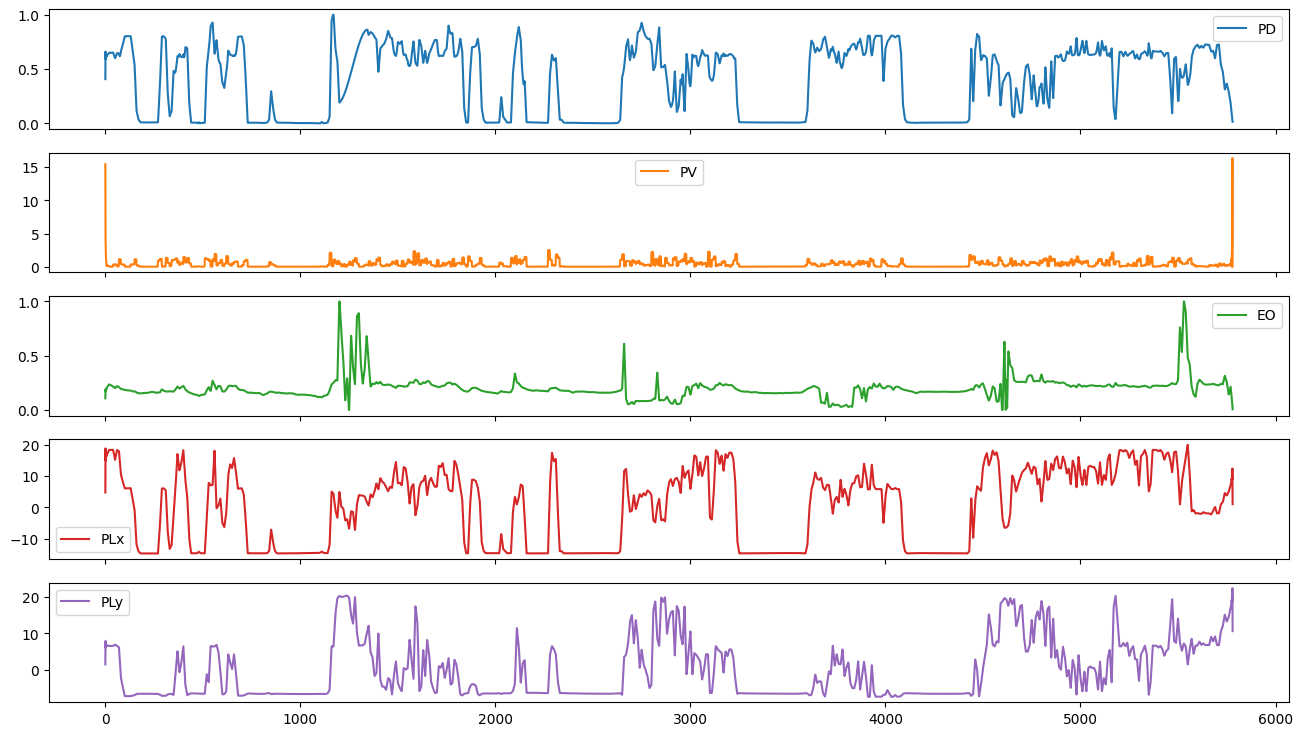

In [7]:
#Plot data
df = pd.concat([pd.read_csv(path, header=None) for path in Path_pupil], axis=1)
df.columns = ["PD", "PV", "EO", "PLx", "PLy"]
df.plot(subplots=True, sharex=True, figsize=(16,9))

# Main

In [8]:
var_dict

{'freq_pupil': 10,
 'freq_hyp': 0.1,
 'length': 1,
 'batch_size': 2048,
 'hidden_dim': 32,
 'layer_num': 1,
 'dropout_rate': 0.5,
 'n_class': 3,
 'weights': tensor([ 1.5800, 19.3000,  3.1600]),
 'lr': 0.00075,
 'test_num': 5,
 'device': device(type='cpu'),
 'random_seed': 123,
 'coordinate_feature': [1, 1, 1, 1, 1, 1, 1, 1],
 'input_dir': 'pupil',
 'data_dim': 5,
 'length_num': 10,
 'filename_list': ['PD_ratio10Hz.csv',
  'Pupil_velocity10Hz.csv',
  'EyeOpening_ratio10Hz.csv',
  'PupilLocation10Hz.csv'],
 'Path_default': '/Users/jamesrowland/Code/Pupil-to-Hypnogram/data/MATLAB'}

In [9]:
#model load
model = LSTM(**var_dict).to(device)
criterion, optimizer = loss_opt(model=model, **var_dict)
# path_load = f'../Data/Intermediate/LSTM/Weights/LSTMoptim.pth'
path_load = "/Users/jamesrowland/Code/Pupil-to-hypnogram-data/Intermediate/LSTM/Weights/LSTMoptim.pth"
checkpoint = torch.load(path_load, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

/var/folders/dq/4604bzr55pd8d08zsts_txvc0000gn/T/ipykernel_6129/14344381.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_load, map_location=

In [10]:
#load data info
df_info = cal_datanum(data_info, **var_dict)
df_info

,animal,data,length,datanum,cum_datanum,start_num
0,jamesrowland,Code,5700,569,569,0


In [11]:
#create dataset and dataloader
Dataset = P2HDataset(data_info=df_info, phase="test", **var_dict)
print(Dataset)
Dataloader = torch.utils.data.DataLoader(
    Dataset,
    batch_size=var_dict['batch_size'],
    drop_last=False
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
phase = 'val'
hyp = []
preds = []
for x in tqdm(Dataloader):
  x = x.float().to(device=device)
  outputs = model(x, var_dict["layer_num"])
  hyp.append(torch.max(outputs[2][:, 0:3], 1)[1].to('cpu').detach().numpy().copy())
  preds.append(outputs[2][:, 0:3].to('cpu').detach().numpy().copy())


/Users/jamesrowland/Code/Pupil-to-Hypnogram/Code/my_module/utils.py:100: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  total_length = int(self.data_info['cum_datanum'][-1:])


  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
df_result = pd.DataFrame([hyp[0], preds[0][:, 0], preds[0][:, 1], preds[0][:, 2]], index=["preds", "lhN", "lhR", "lhW"]).T
df_result.to_csv(f"{Path_default}/estimatedHypnoScore.csv")

In [14]:
df_result.index

RangeIndex(start=0, stop=569, step=1)

In [35]:
def moving_average(arr: np.ndarray, window: int) -> np.ndarray:
    return np.convolve(arr, np.ones(window), "valid") / window

In [36]:
slow_wave = np.load("/Users/jamesrowland/Code/ripples/data/slow_wave.npy")
slow_wave = moving_average(slow_wave, 10)
slow_wave_xaxis = np.linspace(0, len(df_result), len(slow_wave))


Text(0.5, 0, 'Time (s)')

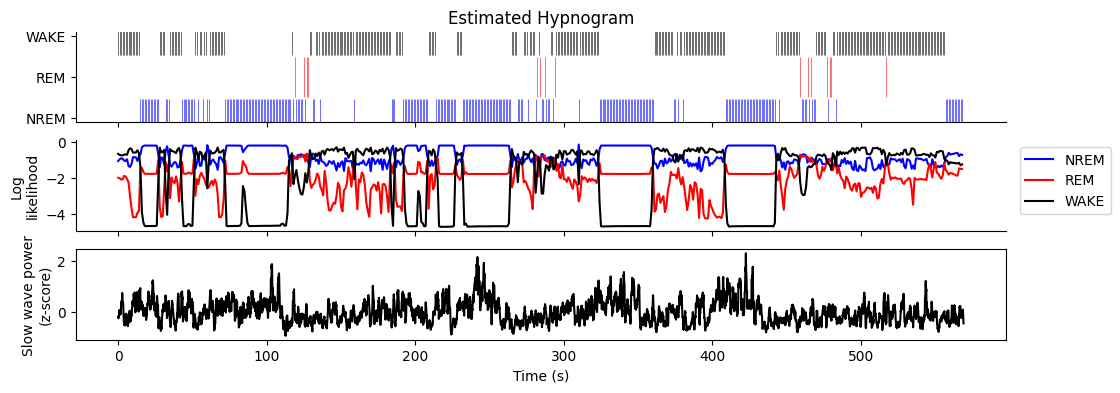

In [43]:

fig, axes = plt.subplots(3,1, figsize=(12, 4), sharex="col")
my_cmap  = ListedColormap(['blue', 'red', 'black'])
width = 0.4
axes[0].scatter(df_result.index, df_result["preds"], c = df_result["preds"], cmap=my_cmap,
                   marker = "|", s=800, linewidths=width)
axes[0].set_title("Estimated Hypnogram")
axes[0].set_yticks([0.0, 1.0, 2.0])
axes[0].set_yticklabels(['NREM', 'REM', 'WAKE'])


t = pd.to_datetime(df_result.index, unit='m') 
    
for i in range(3):
    axes[1].plot(df_result.index, df_result.iloc[:, i+1], color=["blue", "red", "k"][i], label=["NREM", "REM", "WAKE"][i], markersize=1)
axes[1].legend(bbox_to_anchor=(1.12, 1), loc='upper right')
axes[1].set_ylabel("Log\nlikelihood")
# axes[1].set_xticks([0, 360, 720, 1080])
# axes[1].set_xticklabels(["0", "60", "120", "180"])
# axes[1].set_xlabel("Time (min)", fontsize=15)
# axes[1].set_xlim([0, 1080])

[axes[i].spines[j].set_visible(False) for i in range(2) for j in ["top", "right"]]

axes[2].plot(slow_wave_xaxis, slow_wave, color="k")
axes[2].set_ylabel("Slow wave power\n(z-score)")
axes[2].set_xlabel("Time (s)")

# fig.savefig(f'../Data/Outputs/LSTMestimation.png')

In [45]:
t = 325

mins = f"{t//60}:{t%60}"
mins


'5:25'